# Special Feature Selection nodes in TPOT2

TPOT2 can use evolutionary algorithms to optimize feature selection simultaneously with pipeline optimization. There are two node search spaces included.

1. FSSNode - (Feature Set Selector) This node is useful if you have predefined groups of features that you want to select from. For example, one group could include the first x columns, the next group could include the next y columns, etc. Each FeatureSetSelector Node will select a single group to be passed to the next step in the pipeline. This node is also useful if you want to select individual columns at a time, this will be used in tutorial 4 to create a symbolic regression search space. 

2. GeneticFeatureSelectorNode - Whereas FSSNode selects from a predefine list of subsets of features, this node instead uses evolutionary algorithms to optimize a novel subset from scratch. This is useful where there is no predefined grouping of features.


It may also be beneficial to pair these search spaces with a secondary objective function to minimize complexity. That would encourage TPOT to try to produce the simplest pipeline with the fewest number of features.

tpot2.objectives.number_of_nodes_objective - This can be used as an other_objective_function that counts the number of nodes.

tpot2.objectives.complexity_scorer - This is a scorer that can be used in the scorers parameter that tries to count the total number of learned parameters (number of coefficients, number of nodes in decision trees, etc.).


# Feature Set Selector

The FeatureSetSelector is a subclass of sklearn.feature_selection.SelectorMixin that simply returns the manually specified columns. The parameter sel_subset specifies the name or index of the column that it selects. The transform function then simply indexes and returns the selected columns. You can also optionally name the group with the name parameter, though this is only for note keeping and does is not used by the class.


sel_subset: list or int
    If X is a dataframe, items in sel_subset list must correspond to column names
    If X is a numpy array, items in sel_subset list must correspond to column indexes
    int: index of a single column




In [1]:
import tpot2
import pandas as pd
import numpy as np
#make a dataframe with columns a,b,c,d,e,f

#numpy array where columns are 1,2,3,4,5,6
data = np.repeat([np.arange(6)],10,0)

df = pd.DataFrame(data,columns=['a','b','c','d','e','f'])
fss = tpot2.builtin_modules.FeatureSetSelector(name='test',sel_subset=['a','b','c'])

print("original DataFrame")
print(df)
print("Transformed Data")
print(fss.fit_transform(df))

original DataFrame
   a  b  c  d  e  f
0  0  1  2  3  4  5
1  0  1  2  3  4  5
2  0  1  2  3  4  5
3  0  1  2  3  4  5
4  0  1  2  3  4  5
5  0  1  2  3  4  5
6  0  1  2  3  4  5
7  0  1  2  3  4  5
8  0  1  2  3  4  5
9  0  1  2  3  4  5
Transformed Data
[[0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]]


To use the FSS with TPOT2, you can simply pass it in to the configuration dictionary. Note that the FSS is only well defined when used in the leaf nodes of the graph. This is because downstream nodes will receive different transformations of the data such that the original indexes no longer correspond to the same columns in the raw data.

TPOT2 includsing the string "feature_set_selector" in the leaf_config_dict parameter will include the FSS in the search space of the pipeline. By default, each FSS node will select a single column. You can also group columns into sets so that each node selects a set of features rather than a single feature.



subsets : str or list, default=None
        Sets the subsets that the FeatureSetSeletor will select from if set as an option in one of the configuration dictionaries.
        - str : If a string, it is assumed to be a path to a csv file with the subsets. 
            The first column is assumed to be the name of the subset and the remaining columns are the features in the subset.
        - list or np.ndarray : If a list or np.ndarray, it is assumed to be a list of subsets.
        - None : If None, each column will be treated as a subset. One column will be selected per subset.
        If subsets is None, each column will be treated as a subset. One column will be selected per subset.


Lets say you want to have three groups of features, each with three columns each. The following examples are equivalent:

### str

sel_subsets=simple_fss.csv


\# simple_fss.csv

group_one, 1,2,3

group_two, 4,5,6

group_three, 7,8,9


### dict


sel_subsets = { "group_one" :  [1,2,3],
            "group_two" :  [4,5,6],
            "group_three" :  [7,8,9],
            }


### list


sel_subsets = [[1,2,3],[4,5,6],[7,8,9]]



(As the FSS is just another transformer, you could also pass it in with the standard configuration dictionary format (described in tutorial 2), in which you would have to define your own function that returns a hyperparameter. Similar to the  params_LogisticRegression function below. )


(In the future, FSS will be treated as a special case node with its own mutation/crossover functions to make it more efficient when there are large numbers of features.)

In [2]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd


X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=3, n_informative=3, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
X = np.hstack([X, np.random.rand(X.shape[0],6)]) #add six uninformative features
X = pd.DataFrame(X, columns=['a','b','c','d','e','f','g','h','i']) # a, b ,c the rest are uninformative
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

X.head()

,a,b,c,d,e,f,g,h,i
0,1.412867,-1.127143,0.724059,0.012719,0.137617,0.468724,0.287977,0.349621,0.671031
1,-1.459465,0.698617,-0.819786,0.457225,0.567308,0.236609,0.531891,0.682263,0.391485
2,-0.176559,-0.437306,0.261883,0.814360,0.740332,0.244321,0.287691,0.547482,0.936978
3,1.834518,-1.486981,-0.059576,0.533845,0.124767,0.367245,0.755494,0.838529,0.018747
4,1.316622,-0.429921,1.597724,0.804868,0.672430,0.265985,0.262043,0.412193,0.974847


# Feature Set Selector

In this configuration, each FSS node considers a single column.

The root node is a logistic regression and there are no other intermediate transformers. An additional objective function is included that seeks to minimize the number of leave nodes (i.e the number of selected features)

In [ ]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np

subsets = { "group_one" :  ['a','b','c',],
            "group_two" :  ['d','e','f'],
            "group_three" :  ['g','h','i'],
            }

fss_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=subsets)
graph_search_space = tpot2.search_spaces.pipelines.GraphPipeline(
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = None, 
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    max_size = 10,
)

combined_search_space = tpot2.search_spaces.pipelines.SequentialPipeline([fss_search_space, graph_search_space])


est = tpot2.TPOTEstimator(population_size=10,generations=5, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            n_jobs=32,
                            classification=True,
                            search_space = combined_search_space,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation:   0%|          | 0/5 [00:00<?, ?it/s]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.4949171392445077, 0.507750655919077, 0.43525137347874193, 0.517634847479058, 0.503344757388968, 0.8950356124545598, 'INVALID', 0.8871258637584953, 0.5109330298719772, 0.5089602844950213]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.loc[key,column_names] = data
Generation:  20%|██        | 1/5 [00:02<00:08,  2.06s/it]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ind_mutate' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.at[new_child.unique_id(),"

0.936731950844854


In [4]:
est.fitted_pipeline_

Pipeline(steps=[('featuresetselector',
                 FeatureSetSelector(name='group_one',
                                    sel_subset=['a', 'b', 'c'])),
                ('graphpipeline',
                 GraphPipeline(graph=<networkx.classes.digraph.DiGraph object at 0x7ff98829b100>))])

Note that if you want to include multiple subsets, you can instead include the node as a leaf in the graph search space. This will produce a pipeline where all leaves as FSSNodes and all FSSNodes appear in the leaves (to prevent inner nodes from also being FSSNodes). Since the graph search space allows for multiple leaves, this pipeline can select multiple feature sets. 

In [5]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np


graph_search_space = tpot2.search_spaces.pipelines.GraphPipeline(
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=X_train.columns.tolist()), 
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    max_size = 10,
)

est = tpot2.TPOTEstimator(population_size=10,generations=5, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            n_jobs=32,
                            classification=True,
                            search_space = graph_search_space ,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation:   0%|          | 0/5 [00:00<?, ?it/s]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.4971597091828671, 0.5337443085190454, 0.5294751762288605, 0.47021994626205144, 'INVALID', 'INVALID', 0.509353247984827, 0.6309917433222696, 0.4505579674411253, 0.6107437837837837]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.loc[key,column_names] = data
Generation:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ind_mutate' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.at[new_child.unique_id(),"Variati

0.8438300051203278


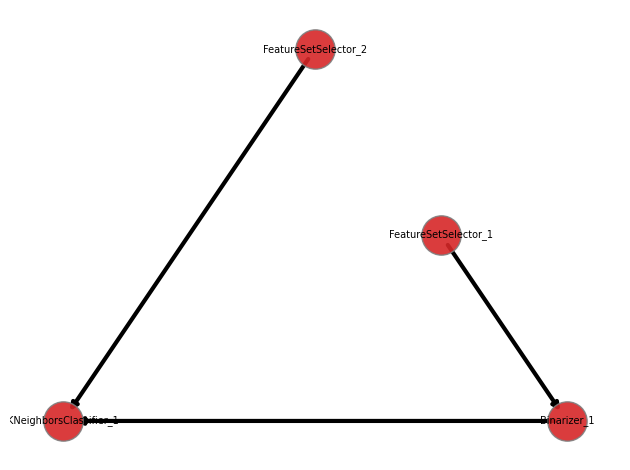

In [6]:
est.fitted_pipeline_.plot()

# Other examples

## dictionary

In [7]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = { "group_one" :  ['a','b','c'],
            "group_two" :  ['d','e','f'],
            "group_three" :  ['g','h','i'],
            }

fss_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=subsets)
graph_search_space = tpot2.search_spaces.pipelines.GraphPipeline(
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = None, 
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    max_size = 10,
)

combined_search_space = tpot2.search_spaces.pipelines.SequentialPipeline([fss_search_space, graph_search_space])


est = tpot2.TPOTEstimator(population_size=10,generations=5, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            n_jobs=32,
                            classification=True,
                            search_space = combined_search_space,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation:   0%|          | 0/5 [00:00<?, ?it/s]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['INVALID', 0.5028790516832622, 0.5150732416627154, 0.9087801390864548, 0.5238396712501976, 0.9130100837679784, 'INVALID', 0.5311821337126601, 0.5578143575154102, 0.9037126031294452]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.loc[key,column_names] = data
Generation:  20%|██        | 1/5 [00:02<00:08,  2.15s/it]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ind_crossover' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.at[new_child.unique_id(),"Vari

0.9381400409626216


## list

In [8]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = [['a','b','c'],['d','e','f'],['g','h','i']]

fss_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=subsets)
graph_search_space = tpot2.search_spaces.pipelines.GraphPipeline(
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = None, 
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    max_size = 10,
)

combined_search_space = tpot2.search_spaces.pipelines.SequentialPipeline([fss_search_space, graph_search_space])


est = tpot2.TPOTEstimator(population_size=10,generations=5, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            n_jobs=32,
                            classification=True,
                            search_space = combined_search_space,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation:   0%|          | 0/5 [00:00<?, ?it/s]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['INVALID', 0.8625720467836258, 0.8566704156788368, 0.5113058289868816, 0.5, 'INVALID', 'INVALID', 0.5475398956851588, 0.47701165165165166, 0.4618115410146989]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.loc[key,column_names] = data
Generation:  20%|██        | 1/5 [00:02<00:08,  2.12s/it]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ind_mutate' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.at[new_child.unique_id(),"Variation_Function"] = var_op


0.9150665642601126


## csv file

note: watch for spaces in the csv file!

In [9]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = 'simple_fss.csv'
'''
# simple_fss.csv
one,a,b,c
two,d,e,f
three,g,h,i
'''

fss_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=subsets)
graph_search_space = tpot2.search_spaces.pipelines.GraphPipeline(
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = None, 
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    max_size = 10,
)

combined_search_space = tpot2.search_spaces.pipelines.SequentialPipeline([fss_search_space, graph_search_space])


est = tpot2.TPOTEstimator(population_size=10,generations=5, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            n_jobs=32,
                            classification=True,
                            search_space = combined_search_space,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation:  20%|██        | 1/5 [00:02<00:08,  2.09s/it]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ind_mutate' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.at[new_child.unique_id(),"Variation_Function"] = var_op
/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5294757388967916, 0.5127661545756282, 0.7694141868183972, 0.4739722617354197, 0.5048332795953848, 0.5087650229176546, 'INVALID', 0.5388487845740478, 0.8611170538960012, 0.8590328718191875]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.loc[key,column_names] = data
Generation: 100%|

0.9415642601126472


note that all of the above is the same when using numpy X, but the column names are now int indeces

In [10]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

n_features = 6
X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=n_features, n_informative=6, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
X = np.hstack([X, np.random.rand(X.shape[0],3)]) #add three uninformative features

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

print(X)

[[ 0.27758401  1.15519074  2.03750167 ...  0.11531653  0.39051724
   0.51339927]
 [ 1.29607496 -0.04247122 -0.18372485 ...  0.269584    0.84277258
   0.44260783]
 [ 0.76010984 -2.16495252  0.18372951 ...  0.36486599  0.24926348
   0.13004702]
 ...
 [-1.74128166 -1.5393641  -3.13674243 ...  0.95560335  0.19956134
   0.40359316]
 [-1.57377697  0.14974153  0.6950208  ...  0.99224155  0.92754033
   0.49321296]
 [-1.74868033  1.62997027 -1.63680993 ...  0.67135722  0.95353672
   0.16306663]]


In [11]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = { "group_one" :  [0,1,2],
            "group_two" :  [3,4,5],
            "group_three" :  [6,7,8],
            }

fss_search_space = tpot2.search_spaces.nodes.FSSNode(subsets=subsets)
graph_search_space = tpot2.search_spaces.pipelines.GraphPipeline(
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = None, 
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    max_size = 10,
)

combined_search_space = tpot2.search_spaces.pipelines.SequentialPipeline([fss_search_space, graph_search_space])


est = tpot2.TPOTEstimator(population_size=10,generations=5, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            n_jobs=32,
                            classification=True,
                            search_space = combined_search_space,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation:   0%|          | 0/5 [00:00<?, ?it/s]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.49615887030270595, 0.6066765489710695, 0.6595343836782194, 0.6364009151680384, 'INVALID', 0.6537323280473967, 0.5037020279314801, 0.7022439255315968, 0.47266157865472935, 0.8024042674727605]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.loc[key,column_names] = data
Generation:  20%|██        | 1/5 [00:02<00:08,  2.15s/it]/home/ribeirop/common/Projects/TPOT_Dev/tpot2/tpot2/population.py:381: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ind_mutate' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.evaluated_individuals.at[new_child.unique_id

0.9583333333333334
